<a href="https://colab.research.google.com/github/Loris99/Axsos_DS/blob/main/Loris_Tarazi__Belt_Exam_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Imports
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
# set random seed
SEED = 321
np.random.seed(SEED)
import statsmodels.tsa.api as tsa
!pip install pmdarima
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs
# set random seed
SEED = 321
np.random.seed(SEED)
sns.set_context('notebook', font_scale=1.2)
plt.rcParams['figure.figsize']=(12,3)


In [9]:
# Import Data
fpath='/content/drive/MyDrive/CodingDojo/04-DataViz/Week14/Data/zillow_home_values-zipcode.csv'
df=pd.read_csv(fpath)
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,31012000,...,28022022,31032022,30042022,31052022,30062022,31072022,31082022,30092022,31102022,30112022
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,107261.0,...,261945.0,267644.0,273946.0,280066.0,285121.0,288532.0,290458.0,291103.0,292081.0,292948.0
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,222569.0,...,453150.0,464727.0,478369.0,489712.0,497173.0,499429.0,497572.0,498113.0,500187.0,503109.0
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,90009.0,...,177319.0,179463.0,182812.0,186403.0,189836.0,192064.0,193760.0,195140.0,196787.0,198137.0
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,188096.0,...,570211.0,572145.0,573662.0,576469.0,578706.0,580834.0,581779.0,584566.0,588188.0,590722.0
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,275983.0,...,752025.0,757734.0,760336.0,766163.0,771443.0,776607.0,779281.0,782367.0,788211.0,793924.0


In [10]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d,
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags,
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [11]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5),
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},
                  annotate_seas=False, m = None,
                 seas_color='black'):

    fig, axes = plt.subplots(nrows=2, figsize=figsize)


    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)

    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)

    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)




    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)

        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()

    return fig

In [12]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None,
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)

    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index,
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();

    return fig, ax

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27442 entries, 0 to 27441
Columns: 284 entries, RegionID to 30112022
dtypes: float64(275), int64(3), object(6)
memory usage: 59.5+ MB


#Part 1

In [15]:
df.isna().sum() / len(df) * 100

,0
RegionID,0.000000
SizeRank,0.000000
RegionName,0.000000
RegionType,0.000000
StateName,0.000000
...,...
31072022,0.721522
31082022,0.630421
30092022,0.502879
31102022,0.327964


In [16]:
melted_df = pd.melt(df, id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType','StateName','State','City','Metro','CountyName'], var_name='Date', value_name='Home Value')
melted_df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Date,Home Value
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,31012000,107261.0
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,31012000,222569.0
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,31012000,90009.0
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,31012000,188096.0
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,31012000,275983.0
...,...,...,...,...,...,...,...,...,...,...,...
7546545,80190,30657,50160,zip,IA,IA,Martensdale,"Des Moines-West Des Moines, IA",Warren County,30112022,193591.0
7546546,65355,30657,18081,zip,PA,PA,Hellertown,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Bucks County,30112022,376523.0
7546547,82217,30657,55366,zip,MN,MN,NaN,NaN,Sibley County,30112022,110082.0
7546548,80581,30657,51009,zip,IA,IA,Calumet,NaN,O Brien County,30112022,75810.0


In [17]:
# Convert the melted dates into datetime datatype
melted_df['Date'] = pd.to_datetime(melted_df['Date'],format='%d%m%Y')
melted_df.info()
melted_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7546550 entries, 0 to 7546549
Data columns (total 11 columns):
 #   Column      Dtype         
---  ------      -----         
 0   RegionID    int64         
 1   SizeRank    int64         
 2   RegionName  int64         
 3   RegionType  object        
 4   StateName   object        
 5   State       object        
 6   City        object        
 7   Metro       object        
 8   CountyName  object        
 9   Date        datetime64[ns]
 10  Home Value  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 633.3+ MB


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Date,Home Value
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,2000-01-31,107261.0
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,2000-01-31,222569.0
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,2000-01-31,90009.0
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-01-31,188096.0
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-01-31,275983.0
...,...,...,...,...,...,...,...,...,...,...,...
7546545,80190,30657,50160,zip,IA,IA,Martensdale,"Des Moines-West Des Moines, IA",Warren County,2022-11-30,193591.0
7546546,65355,30657,18081,zip,PA,PA,Hellertown,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Bucks County,2022-11-30,376523.0
7546547,82217,30657,55366,zip,MN,MN,NaN,NaN,Sibley County,2022-11-30,110082.0
7546548,80581,30657,51009,zip,IA,IA,Calumet,NaN,O Brien County,2022-11-30,75810.0


In [18]:
# Make the datetime column the index
melted_df.set_index('Date', inplace=True)
melted_df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Home Value
Date,,,,,,,,,,
2000-01-31,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,107261.0
2000-01-31,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,222569.0
2000-01-31,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,90009.0
2000-01-31,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,188096.0
2000-01-31,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,275983.0
...,...,...,...,...,...,...,...,...,...,...
2022-11-30,80190,30657,50160,zip,IA,IA,Martensdale,"Des Moines-West Des Moines, IA",Warren County,193591.0
2022-11-30,65355,30657,18081,zip,PA,PA,Hellertown,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Bucks County,376523.0
2022-11-30,82217,30657,55366,zip,MN,MN,NaN,NaN,Sibley County,110082.0


In [19]:
# Keep only the relevant states
states_to_keep = ['CA', 'WA', 'OR', 'AZ', 'NV']
melted_df = melted_df[melted_df['State'].isin(states_to_keep)]
melted_df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Home Value
Date,,,,,,,,,,
2000-01-31,95992,5,90011,zip,CA,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,143426.0
2000-01-31,96361,8,91331,zip,CA,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,144841.0
2000-01-31,96193,9,90650,zip,CA,CA,Norwalk,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,163955.0
2000-01-31,96083,12,90201,zip,CA,CA,Bell,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,163273.0
2000-01-31,96816,13,92335,zip,CA,CA,Fontana,"Riverside-San Bernardino-Ontario, CA",San Bernardino County,110958.0
...,...,...,...,...,...,...,...,...,...,...
2022-11-30,98502,30657,95950,zip,CA,CA,Grimes,NaN,Colusa County,313005.0
2022-11-30,95776,30657,89041,zip,NV,NV,Pahrump,"Pahrump, NV",Nye County,414072.0
2022-11-30,99923,30657,98623,zip,WA,WA,White Salmon,NaN,Klickitat County,729920.0


In [20]:
melted_df = melted_df.loc['2010-01-01':'2020-12-31']
melted_df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Home Value
Date,,,,,,,,,,
2010-01-31,95992,5,90011,zip,CA,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,209250.0
2010-01-31,96361,8,91331,zip,CA,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,257372.0
2010-01-31,96193,9,90650,zip,CA,CA,Norwalk,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,296430.0
2010-01-31,96083,12,90201,zip,CA,CA,Bell,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,271829.0
2010-01-31,96816,13,92335,zip,CA,CA,Fontana,"Riverside-San Bernardino-Ontario, CA",San Bernardino County,156704.0
...,...,...,...,...,...,...,...,...,...,...
2020-12-31,98502,30657,95950,zip,CA,CA,Grimes,NaN,Colusa County,220881.0
2020-12-31,95776,30657,89041,zip,NV,NV,Pahrump,"Pahrump, NV",Nye County,NaN
2020-12-31,99923,30657,98623,zip,WA,WA,White Salmon,NaN,Klickitat County,538209.0


In [21]:
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 386892 entries, 2010-01-31 to 2020-12-31
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   RegionID    386892 non-null  int64  
 1   SizeRank    386892 non-null  int64  
 2   RegionName  386892 non-null  int64  
 3   RegionType  386892 non-null  object 
 4   StateName   386892 non-null  object 
 5   State       386892 non-null  object 
 6   City        374748 non-null  object 
 7   Metro       352308 non-null  object 
 8   CountyName  386892 non-null  object 
 9   Home Value  361506 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 32.5+ MB


In [22]:
melted_df['Home Value'].isna().sum() / len(melted_df) * 100

6.56152104463261

only 6% of the data is null! I either use the mean or drop, because each year can vary,I have decided to fill each year's missing value with that year's average of home values, so they can be relevant to the year

In [23]:
# Extract the year from the Date index
melted_df['Year'] = melted_df.index.year

# Calculate the mean home value for each year
mean_values = melted_df.groupby('Year')['Home Value'].mean()
mean_values

<ipython-input-23-dd36a8b667fe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  melted_df['Year'] = melted_df.index.year


,Home Value
Year,
2010,325587.199011
2011,302026.094676
2012,301313.676014
2013,345791.781459
2014,381533.267889
2015,404710.993649
2016,432536.806758
2017,461325.822444
2018,497370.426893


In [24]:
# Fill missing values based on the mean of each year
for year in mean_values.index:
    melted_df.loc[(melted_df['Year'] == year) & (melted_df['Home Value'].isna()), 'Home Value'] = mean_values[year]

In [25]:
#check for misisng values
melted_df['Home Value'].isna().sum() / len(melted_df) * 100

0.0

In [26]:
melted_df.drop(columns='Year', inplace=True)


<ipython-input-26-e5799066e399>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  melted_df.drop(columns='Year', inplace=True)


In [27]:
melted_df['Home Value'] = pd.to_numeric(melted_df['Home Value'], errors='coerce')
melted_df.info()

<ipython-input-27-f08cfad59ea3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  melted_df['Home Value'] = pd.to_numeric(melted_df['Home Value'], errors='coerce')


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 386892 entries, 2010-01-31 to 2020-12-31
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   RegionID    386892 non-null  int64  
 1   SizeRank    386892 non-null  int64  
 2   RegionName  386892 non-null  int64  
 3   RegionType  386892 non-null  object 
 4   StateName   386892 non-null  object 
 5   State       386892 non-null  object 
 6   City        374748 non-null  object 
 7   Metro       352308 non-null  object 
 8   CountyName  386892 non-null  object 
 9   Home Value  386892 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 32.5+ MB


In [28]:
#Resample the home values, grouped by states, to a yearly frequency (based on the beginning of the calendar year) using the mean as the aggregation function.
yearly_mean = melted_df.groupby('State').resample('Y')['Home Value'].mean()
yearly_mean

State  Date      
AZ     2010-12-31    181326.288713
       2011-12-31    163002.477708
       2012-12-31    169814.087104
       2013-12-31    194348.340989
       2014-12-31    210047.232302
       2015-12-31    219830.756333
       2016-12-31    229960.280819
       2017-12-31    242451.717181
       2018-12-31    258202.240898
       2019-12-31    267600.023331
       2020-12-31    286918.315000
CA     2010-12-31    407790.189489
       2011-12-31    381566.781345
       2012-12-31    382360.672667
       2013-12-31    447702.007506
       2014-12-31    498783.546135
       2015-12-31    528379.015928
       2016-12-31    563101.887646
       2017-12-31    596157.786937
       2018-12-31    642443.864275
       2019-12-31    645392.686552
       2020-12-31    671461.798503
NV     2010-12-31    206362.769690
       2011-12-31    184753.966966
       2012-12-31    179142.715810
       2013-12-31    214135.781052
       2014-12-31    243910.900353
       2015-12-31    262134.100220
       2016-12-31    280928.684554
       2017-12-31    300614.363812
       2018-12-31    336728.510496
       2019-12-31    351998.264868
       2020-12-31    365534.577741
OR     2010-12-31    236810.191245
       2011-12-31    216229.552274
       2012-12-31    213066.147625
       2013-12-31    230406.070577
       2014-12-31    247466.726055
       2015-12-31    264539.727243
       2016-12-31    286096.148568
       2017-12-31    308958.001759
       2018-12-31    324646.901903
       2019-12-31    335688.397320
       2020-12-31    349265.284385
WA     2010-12-31    262175.383153
       2011-12-31    240768.501398
       2012-12-31    234026.790336
       2013-12-31    249858.230135
       2014-12-31    266649.744393
       2015-12-31    284423.215072
       2016-12-31    309245.680678
       2017-12-31    341786.882513
       2018-12-31    373718.917192
       2019-12-31    387499.358770
       2020-12-31    413410.157771
Name: Home Value, dtype: float64

In [29]:
# level 0 is states
yearly_mean.index.get_level_values(0)

Index(['AZ', 'AZ', 'AZ', 'AZ', 'AZ', 'AZ', 'AZ', 'AZ', 'AZ', 'AZ', 'AZ', 'CA',
       'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'NV', 'NV',
       'NV', 'NV', 'NV', 'NV', 'NV', 'NV', 'NV', 'NV', 'NV', 'OR', 'OR', 'OR',
       'OR', 'OR', 'OR', 'OR', 'OR', 'OR', 'OR', 'OR', 'WA', 'WA', 'WA', 'WA',
       'WA', 'WA', 'WA', 'WA', 'WA', 'WA', 'WA'],
      dtype='object', name='State')

In [30]:
# level 1 is variable/dates
yearly_mean.index.get_level_values(1)

DatetimeIndex(['2010-12-31', '2011-12-31', '2012-12-31', '2013-12-31',
               '2014-12-31', '2015-12-31', '2016-12-31', '2017-12-31',
               '2018-12-31', '2019-12-31', '2020-12-31', '2010-12-31',
               '2011-12-31', '2012-12-31', '2013-12-31', '2014-12-31',
               '2015-12-31', '2016-12-31', '2017-12-31', '2018-12-31',
               '2019-12-31', '2020-12-31', '2010-12-31', '2011-12-31',
               '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31',
               '2016-12-31', '2017-12-31', '2018-12-31', '2019-12-31',
               '2020-12-31', '2010-12-31', '2011-12-31', '2012-12-31',
               '2013-12-31', '2014-12-31', '2015-12-31', '2016-12-31',
               '2017-12-31', '2018-12-31', '2019-12-31', '2020-12-31',
               '2010-12-31', '2011-12-31', '2012-12-31', '2013-12-31',
               '2014-12-31', '2015-12-31', '2016-12-31', '2017-12-31',
               '2018-12-31', '2019-12-31', '2020-12-31'],
              dtype

In [31]:
#Plot the home values for all 5 states.
unstacked = yearly_mean.unstack(level=0)
unstacked

State,AZ,CA,NV,OR,WA
Date,,,,,
2010-12-31,181326.288713,407790.189489,206362.769690,236810.191245,262175.383153
2011-12-31,163002.477708,381566.781345,184753.966966,216229.552274,240768.501398
2012-12-31,169814.087104,382360.672667,179142.715810,213066.147625,234026.790336
2013-12-31,194348.340989,447702.007506,214135.781052,230406.070577,249858.230135
2014-12-31,210047.232302,498783.546135,243910.900353,247466.726055,266649.744393
2015-12-31,219830.756333,528379.015928,262134.100220,264539.727243,284423.215072
2016-12-31,229960.280819,563101.887646,280928.684554,286096.148568,309245.680678
2017-12-31,242451.717181,596157.786937,300614.363812,308958.001759,341786.882513
2018-12-31,258202.240898,642443.864275,336728.510496,324646.901903,373718.917192


<ipython-input-32-0d1cfa11e2b8>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


[Text(40, 0, '2010'),
 Text(42, 0, '2012'),
 Text(44, 0, '2014'),
 Text(46, 0, '2016'),
 Text(48, 0, '2018'),
 Text(50, 0, '2020')]

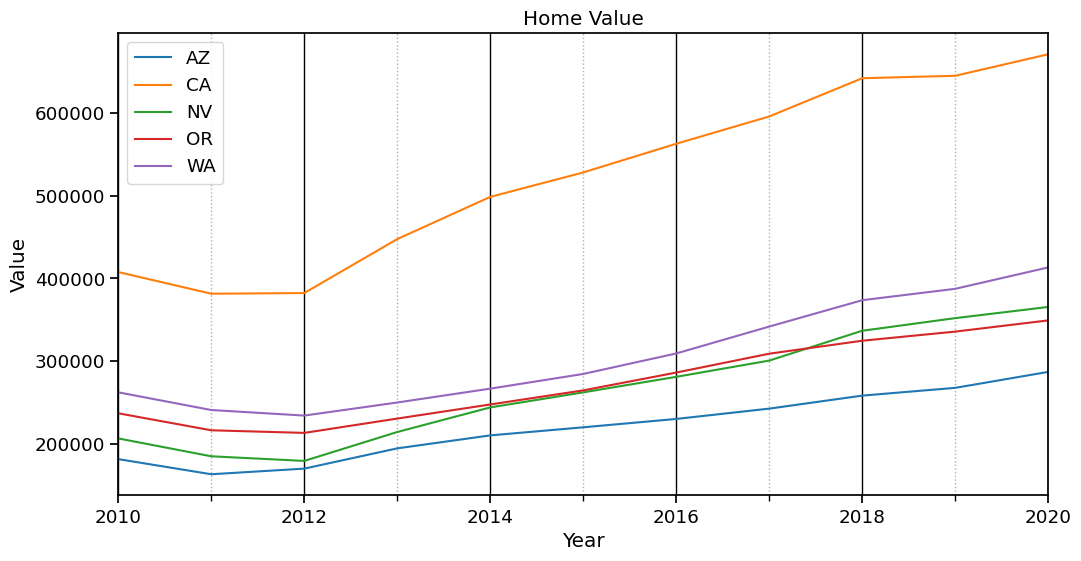

In [32]:
# Making visualization plot
ax=unstacked.plot(figsize=(12,6),title='Home Value');
ax.legend();
ax.set_ylabel('Value')
ax.set_xlabel('Year')
# Get the current x-tick labels
labels = ax.get_xticklabels()
## Making major/minor gridlines visually distinct
ax.grid(which='minor',axis='x',ls=":")
ax.grid(which='major',axis='x',color='k')
# Set the x-tick labels
ax.set_xticklabels(labels)


We can see from our plot here that california has always had the higest valeu of all, and their ratio has almost always stayed the same however, oregon and nivada  (red and green), notice how at the end of 2017 nivada started havoing higher value  than oregon!

#Part 2

###The goal of this section will be to forecast the average home price in the state of Oregon for the next 12 months. The forecast will be based on data from 2000-2018.

In [33]:
df2 = pd.melt(df, id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType','StateName','State','City','Metro','CountyName'], var_name='Date', value_name='Home Value')
df2

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Date,Home Value
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,31012000,107261.0
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,31012000,222569.0
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,31012000,90009.0
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,31012000,188096.0
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,31012000,275983.0
...,...,...,...,...,...,...,...,...,...,...,...
7546545,80190,30657,50160,zip,IA,IA,Martensdale,"Des Moines-West Des Moines, IA",Warren County,30112022,193591.0
7546546,65355,30657,18081,zip,PA,PA,Hellertown,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Bucks County,30112022,376523.0
7546547,82217,30657,55366,zip,MN,MN,NaN,NaN,Sibley County,30112022,110082.0
7546548,80581,30657,51009,zip,IA,IA,Calumet,NaN,O Brien County,30112022,75810.0


In [34]:
# Convert the melted dates into datetime datatype
df2['Date'] = pd.to_datetime(df2['Date'],format='%d%m%Y')
df2.info()
df2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7546550 entries, 0 to 7546549
Data columns (total 11 columns):
 #   Column      Dtype         
---  ------      -----         
 0   RegionID    int64         
 1   SizeRank    int64         
 2   RegionName  int64         
 3   RegionType  object        
 4   StateName   object        
 5   State       object        
 6   City        object        
 7   Metro       object        
 8   CountyName  object        
 9   Date        datetime64[ns]
 10  Home Value  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 633.3+ MB


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Date,Home Value
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,2000-01-31,107261.0
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,2000-01-31,222569.0
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,2000-01-31,90009.0
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-01-31,188096.0
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-01-31,275983.0
...,...,...,...,...,...,...,...,...,...,...,...
7546545,80190,30657,50160,zip,IA,IA,Martensdale,"Des Moines-West Des Moines, IA",Warren County,2022-11-30,193591.0
7546546,65355,30657,18081,zip,PA,PA,Hellertown,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Bucks County,2022-11-30,376523.0
7546547,82217,30657,55366,zip,MN,MN,NaN,NaN,Sibley County,2022-11-30,110082.0
7546548,80581,30657,51009,zip,IA,IA,Calumet,NaN,O Brien County,2022-11-30,75810.0


In [35]:
# Make the datetime column the index
df2.set_index('Date', inplace=True)
df2

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Home Value
Date,,,,,,,,,,
2000-01-31,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,107261.0
2000-01-31,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,222569.0
2000-01-31,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,90009.0
2000-01-31,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,188096.0
2000-01-31,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,275983.0
...,...,...,...,...,...,...,...,...,...,...
2022-11-30,80190,30657,50160,zip,IA,IA,Martensdale,"Des Moines-West Des Moines, IA",Warren County,193591.0
2022-11-30,65355,30657,18081,zip,PA,PA,Hellertown,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Bucks County,376523.0
2022-11-30,82217,30657,55366,zip,MN,MN,NaN,NaN,Sibley County,110082.0


In [36]:
# Keep only the relevant states
filtered_df = df2[(df2['StateName'] == 'OR')]
filtered_df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Home Value
Date,,,,,,,,,,
2000-01-31,99142,262,97229,zip,OR,OR,Portland,"Portland-Vancouver-Hillsboro, OR-WA",Washington County,260209.0
2000-01-31,99178,489,97301,zip,OR,OR,Salem,"Salem, OR",Marion County,109851.0
2000-01-31,99048,528,97045,zip,OR,OR,Oregon City,"Portland-Vancouver-Hillsboro, OR-WA",Clackamas County,204570.0
2000-01-31,99093,549,97124,zip,OR,OR,Hillsboro,"Portland-Vancouver-Hillsboro, OR-WA",Washington County,181574.0
2000-01-31,99252,656,97402,zip,OR,OR,Eugene,"Eugene-Springfield, OR",Lane County,136799.0
...,...,...,...,...,...,...,...,...,...,...
2022-11-30,99279,30657,97432,zip,OR,OR,Winston,"Roseburg, OR",Douglas County,226951.0
2022-11-30,99025,30657,97020,zip,OR,OR,Donald,"Salem, OR",Marion County,470690.0
2022-11-30,99101,30657,97134,zip,OR,OR,Tillamook,NaN,Tillamook County,606334.0


In [37]:
#filter the years
filtered_df = filtered_df.loc['2000-01-01':'2018-12-31']
filtered_df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Home Value
Date,,,,,,,,,,
2000-01-31,99142,262,97229,zip,OR,OR,Portland,"Portland-Vancouver-Hillsboro, OR-WA",Washington County,260209.0
2000-01-31,99178,489,97301,zip,OR,OR,Salem,"Salem, OR",Marion County,109851.0
2000-01-31,99048,528,97045,zip,OR,OR,Oregon City,"Portland-Vancouver-Hillsboro, OR-WA",Clackamas County,204570.0
2000-01-31,99093,549,97124,zip,OR,OR,Hillsboro,"Portland-Vancouver-Hillsboro, OR-WA",Washington County,181574.0
2000-01-31,99252,656,97402,zip,OR,OR,Eugene,"Eugene-Springfield, OR",Lane County,136799.0
...,...,...,...,...,...,...,...,...,...,...
2018-12-31,99279,30657,97432,zip,OR,OR,Winston,"Roseburg, OR",Douglas County,163902.0
2018-12-31,99025,30657,97020,zip,OR,OR,Donald,"Salem, OR",Marion County,327667.0
2018-12-31,99101,30657,97134,zip,OR,OR,Tillamook,NaN,Tillamook County,397175.0


In [38]:
filtered_df.isna().sum()

,0
RegionID,0
SizeRank,0
RegionName,0
RegionType,0
StateName,0
State,0
City,3192
Metro,9804
CountyName,0
Home Value,16702


I will drop city and metro as they are irrelevant to what we need to predict the values for the oregon state,and will replace the values by the average of that year..

In [39]:
filtered_df.drop(columns=['City','Metro'],inplace=True)

<ipython-input-39-324eecb61900>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop(columns=['City','Metro'],inplace=True)


In [40]:
# Extract the year from the Date index
filtered_df['Year'] = filtered_df.index.year

# Calculate the mean home value for each year
mean_values = filtered_df.groupby('Year')['Home Value'].mean()
mean_values

<ipython-input-40-7e93d4217a50>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = filtered_df.index.year


,Home Value
Year,
2000,164866.147130
2001,171488.954593
2002,178160.261640
2003,186240.031687
2004,202457.704271
2005,232914.075356
2006,272455.861326
2007,291040.966934
2008,276209.651324


In [41]:
# Fill missing values based on the mean of each year
for year in mean_values.index:
    filtered_df.loc[(filtered_df['Year'] == year) & (filtered_df['Home Value'].isna()), 'Home Value'] = mean_values[year]

In [42]:
#check for misisng values
filtered_df['Home Value'].isna().sum() / len(filtered_df) * 100

0.0

In [43]:
filtered_df.drop(columns='Year', inplace=True)
filtered_df

<ipython-input-43-6e5d5f8841b6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop(columns='Year', inplace=True)


,RegionID,SizeRank,RegionName,RegionType,StateName,State,CountyName,Home Value
Date,,,,,,,,
2000-01-31,99142,262,97229,zip,OR,OR,Washington County,260209.00000
2000-01-31,99178,489,97301,zip,OR,OR,Marion County,109851.00000
2000-01-31,99048,528,97045,zip,OR,OR,Clackamas County,204570.00000
2000-01-31,99093,549,97124,zip,OR,OR,Washington County,181574.00000
2000-01-31,99252,656,97402,zip,OR,OR,Lane County,136799.00000
...,...,...,...,...,...,...,...,...
2018-12-31,99279,30657,97432,zip,OR,OR,Douglas County,163902.00000
2018-12-31,99025,30657,97020,zip,OR,OR,Marion County,327667.00000
2018-12-31,99101,30657,97134,zip,OR,OR,Tillamook County,397175.00000


In [44]:
filtered_df.isna().sum()

,0
RegionID,0
SizeRank,0
RegionName,0
RegionType,0
StateName,0
State,0
CountyName,0
Home Value,0


In [45]:
ts = filtered_df.resample('M')['Home Value'].mean()

<Axes: xlabel='Date'>

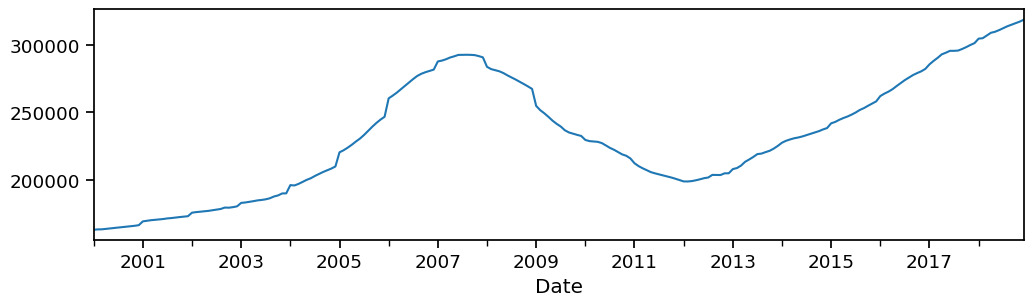

In [46]:
ts.plot()

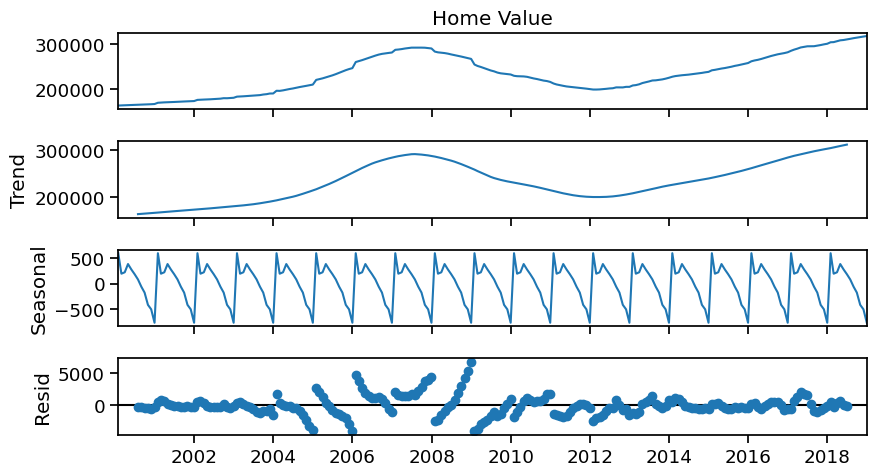

In [47]:
## Use Seasonal Decompose to check for seasonality
decomp = tsa.seasonal_decompose(ts)
fig = decomp.plot()
fig.set_size_inches(9, 5)
fig.tight_layout()

In [48]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()
# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta: .2f} which is {(seasonal_delta/(ts.max()-ts.min())) * 100}% of the variation in time series")

The seasonal component is  1357.44 which is 0.8747523707141063% of the variation in time series


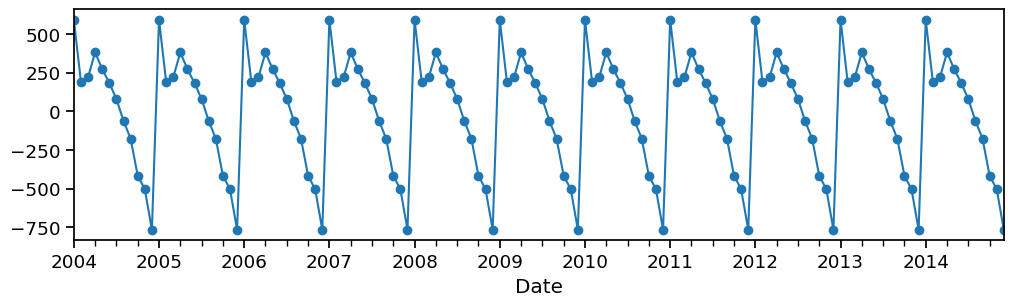

In [49]:
# Narrow down the date range of the plot
seasonal = decomp.seasonal
ax = seasonal.loc['2004':'2014'].plot(marker = 'o')

we obviously have a seasonal data, which occurs every year, so m-12 for 12 months

In [50]:
# Check for stationarity
get_adfuller_results(ts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-1.96698,15,212,0.301236,0.05,False


In [51]:
ts_diff = ts.diff().dropna()
get_adfuller_results(ts_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-1.924044,14,212,0.320836,0.05,False


In [52]:
# Determine differencing
d = ndiffs(ts)
print(f'd is {d}')
D = nsdiffs(ts, m =12)
print(f'D is {D}')


d is 1
D is 0


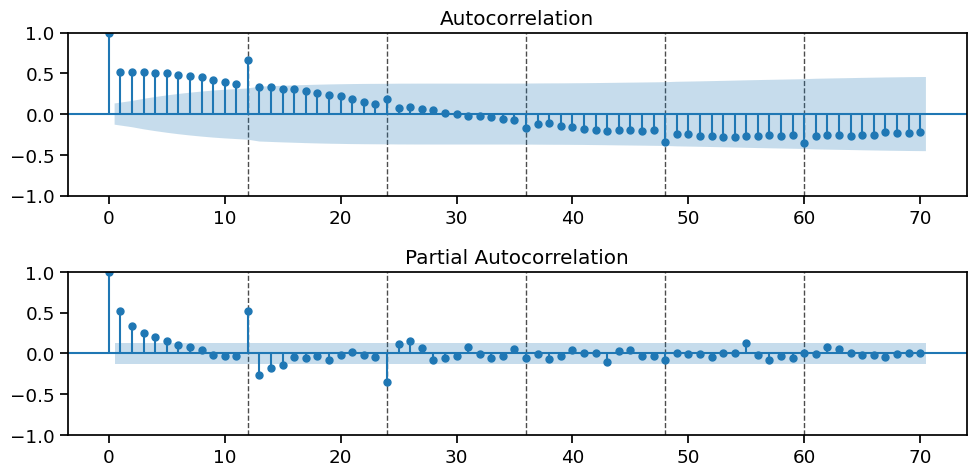

In [53]:
# We can use our function to highlight the seasonal lags by adding the arguments
plot_acf_pacf(ts_diff, annotate_seas = True, m = 12, nlags = 70);

acf gradually decreases then at the last there's a slight increase, while the pcsf there's a drop after the 2nd lag!

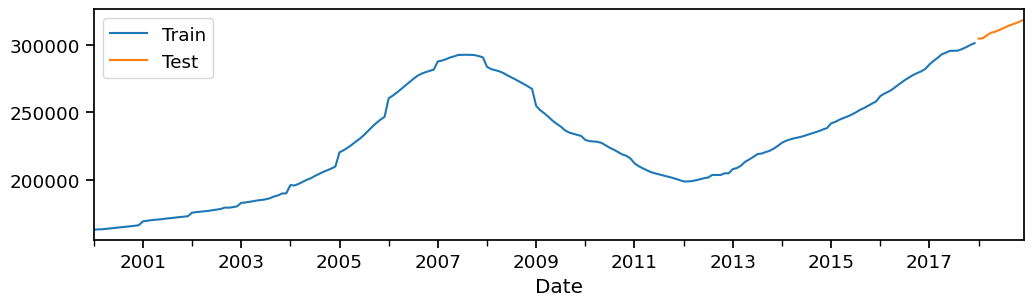

In [70]:
# tts
train, test = train_test_split(ts, test_size=12)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [55]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA

# Orders for seasonal components
P = 2  # Seasonal AR
D = 0  # Seasonal differencing
Q = 0  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                       Home Value   No. Observations:                  216
Model:             ARIMA(1, 1, 0)x(2, 0, 0, 12)   Log Likelihood               -1957.275
Date:                          Mon, 23 Sep 2024   AIC                           3922.549
Time:                                  02:14:20   BIC                           3936.032
Sample:                              01-31-2000   HQIC                          3927.997
                                   - 12-31-2017                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0337      0.007      4.958      0.000       0.020       0.047
ar.S.L12       0.0573      0.006      9.776      0.000       0.046       0.069
ar.S.L24       0.0264      0.018      1.500      0.134      -0.008       0.061
sigma2      3.475e+06   9.96e+04     34.903      0.000    3.28e+06    3.67e+06
===================================================================================
Ljung-Box (L1) (Q):                  47.29   Jarque-Bera (JB):              1685.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

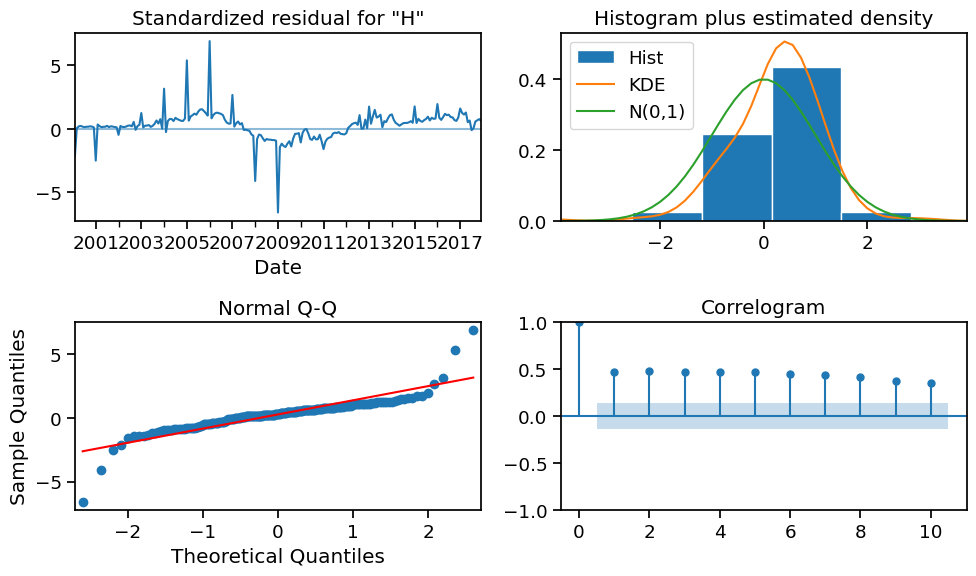

In [71]:
# Obtain diagnostic plots
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

there are no significant lags in the ocrrelogram

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 9,129.826
- MSE = 99,789,367.272
- RMSE = 9,989.463
- R^2 = -3.985
- MAPE = 2.91%


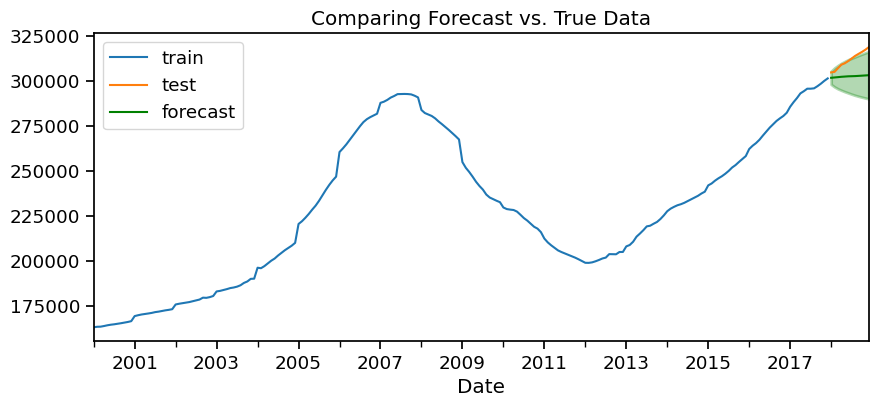

In [72]:
# Obtain forecast as a dataframe with confidence intervals
forecast_df = sarima.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

Tune with pmdarima's auto_arima


In [73]:
import pmdarima as pm

# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima( train, seasonal=True,m=12,trace=True)
# the auto_arima will store our best nonseasonal and seasonal orders separtely
print(auto_model.order)
print(auto_model.seasonal_order)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=3911.694, Time=3.18 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3912.366, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3912.644, Time=0.55 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3904.318, Time=1.32 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3928.804, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=3912.017, Time=0.20 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=3905.767, Time=1.74 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=3904.499, Time=0.50 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=3903.987, Time=0.19 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=3904.571, Time=0.43 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=3906.433, Time=0.83 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=3904.430, Time=0.21 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=3911.406, Time=0.36 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=3904.801, Time=0.26 sec
 ARIMA(1,1,2)(1,0,0

In [74]:
# Obtain summary of the best model from auto_arima
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  216
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 12)   Log Likelihood               -1947.993
Date:                             Mon, 23 Sep 2024   AIC                           3903.987
Time:                                     02:23:57   BIC                           3917.470
Sample:                                 01-31-2000   HQIC                          3909.435
                                      - 12-31-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    603.0750    155.500      3.878      0.000     298.300     907.850
ma.L1          0.0222      0.010      2.187      0.029       0.002       0.042
ar.S.L12       0.0489      0.008      6.262      0.000       0.034       0.064
sigma2      4.515e+06   1.68e+05     26.886      0.000    4.19e+06    4.84e+06
===================================================================================
Ljung-Box (L1) (Q):                  51.15   Jarque-Bera (JB):              1650.66
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

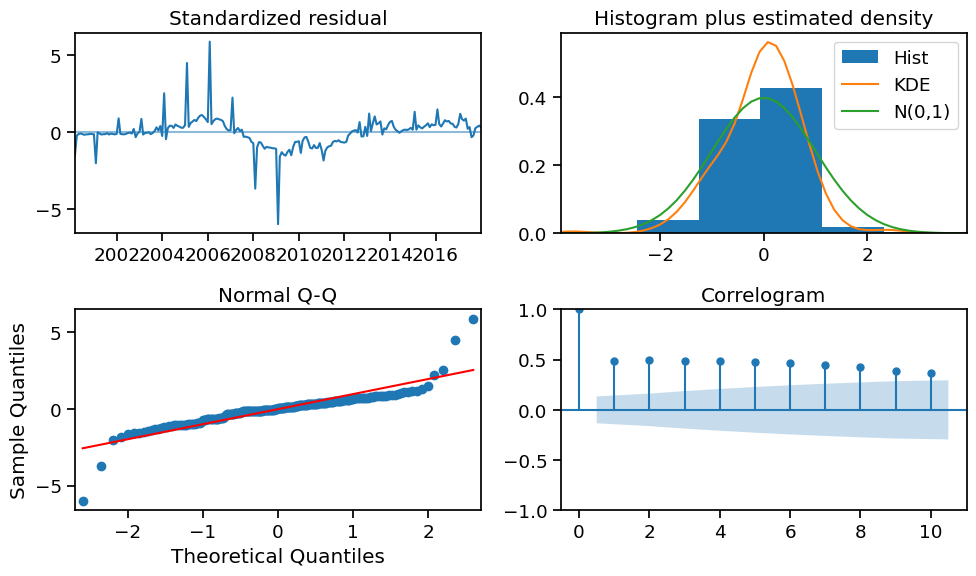

In [75]:
# Obtain diagnostic plots
fig = auto_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

we cna ee how this is better hte ocrrelogram has more shaded area


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 9,534.565
- MSE = 108,829,308.341
- RMSE = 10,432.129
- R^2 = -4.436
- MAPE = 3.04%


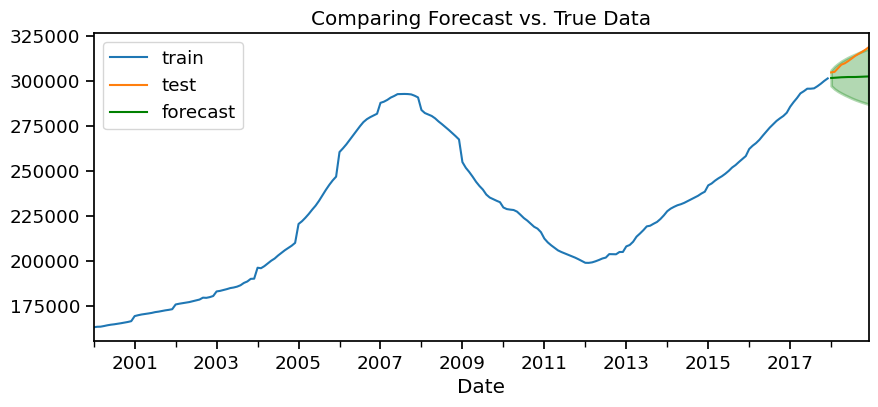

In [76]:
# Use auto_arima parameters to fit an ARIMA
auto_model = tsa.ARIMA(
    train, order=auto_model.order, seasonal_order=auto_model.seasonal_order
).fit()


# Obtain forecast as a dataframe with confidence intervals
forecast_df = auto_model.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

In [100]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA

# Orders for seasonal components
P = 2  # Seasonal AR
D = 0  # Seasonal differencing
Q = 0  # Seasonal MA
m = 12 # Seasonal period

final_model = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()


for final model I chose the ifrst ine as it shows beter reults in terms that it  has lower MAE, MSE, and RMSE, indicating better performance in terms of prediction accuracy. MAPE is lower in the first set, indicating a better percentage error in predictions.

In [101]:
len(test)

12

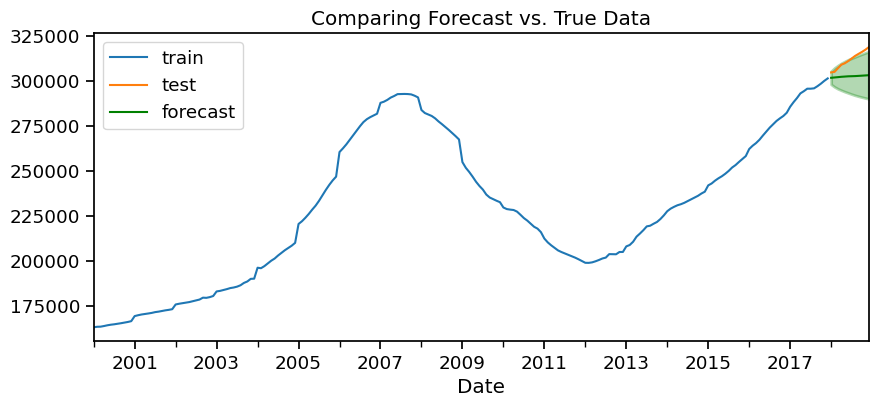

In [102]:
# Obtain future forecasts beyond test data
forecast_df  = final_model.get_forecast(len(test)).summary_frame()
plot_forecast(train,test,forecast_df);

we can see that the prediciton data forecats is close to the test data

In [103]:
forecast_df.index[0],forecast_df.index[-1]

(Timestamp('2018-01-31 00:00:00'), Timestamp('2018-12-31 00:00:00'))

In [104]:
starting_value = forecast_df['mean'].iloc[0]
starting_value


301573.2751269165

In [105]:
final_value = forecast_df['mean'].iloc[-1]
final_value

303004.2690477462

In [106]:
change = final_value - starting_value
change

1430.9939208297292

so over our period of 12 months our home values will increase by only 1430 in values!

In [107]:
perc_change = (change / starting_value) * 100
perc_change

0.474509526823124

so this is a very small percentage, in which the values increase bye! regarding our model!
